# Probing Many-Body Dynamics on Pulser

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Pulse, Sequence, Register
from pulser.waveforms import CompositeWaveform, RampWaveform, ConstantWaveform
from pulser.devices import Chadoq2, Mock
from pulser.simulation import Simulation

In [13]:
# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -20 * 2*np.pi
delta_f = 20 * 2*np.pi
Omega_max = 2 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 600
t_stop = 2500
t_end = 3000

Blockade Radius is: 8.578454972350485µm.


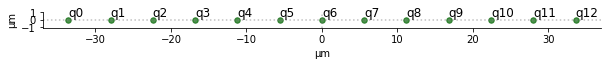

In [14]:
R_blockade = (5.008e6/Omega_max)**(1/6)
reg = Register.rectangle(1,13, spacing=5.6, prefix='q')
print(f'Blockade Radius is: {R_blockade}µm.')
reg.draw()

## Z2 order: Creating the Pulse Sequence

In [15]:
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

Channel: ising
t: 0 | Initial targets: q12, q0, q10, q1, q6, q7, q2, q9, q8, q5, q11, q4, q3 | Phase Reference: 0.0 
t: 0->2500 | Pulse(Amp=12.6 MHz, Detuning=Composite(ConstantWaveform(600 ns, -126 MHz), RampWaveform(1900 ns, -126->126 MHz)), Phase=0) | Targets: q12, q0, q10, q1, q6, q7, q2, q9, q8, q5, q11, q4, q3
t: 2500->3000 | Pulse(Amp=0 MHz, Detuning=126 MHz, Phase=0) | Targets: q12, q0, q10, q1, q6, q7, q2, q9, q8, q5, q11, q4, q3




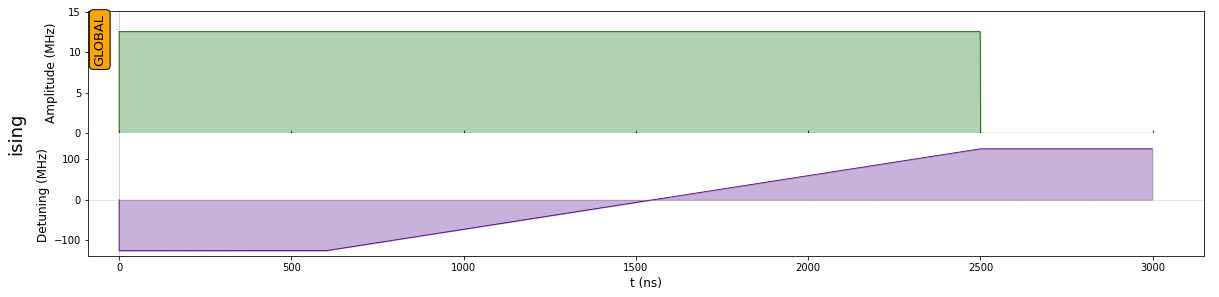

In [16]:
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

print(seq)
seq.draw()

## Simulation

(Running with `nsteps = 1000`, `max_step=20`)

In [17]:
simul = Simulation(seq)
print(simul._U, Omega_max, simul._U/Omega_max)

162.38135391078646 12.566370614359172 12.921897570428069


In [18]:
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

In [19]:
simul.run(obs_list=occup_list, progress_bar=True)
res = simul.output.expect

Observables provided. Calculating expectation value...
10.0%. Run time:   3.51s. Est. time left: 00:00:00:31
20.0%. Run time:   6.57s. Est. time left: 00:00:00:26
30.0%. Run time:   9.51s. Est. time left: 00:00:00:22
40.0%. Run time:  12.30s. Est. time left: 00:00:00:18
50.0%. Run time:  14.84s. Est. time left: 00:00:00:14
60.0%. Run time:  17.76s. Est. time left: 00:00:00:11
70.0%. Run time:  21.82s. Est. time left: 00:00:00:09
80.0%. Run time:  26.27s. Est. time left: 00:00:00:06
90.0%. Run time:  30.87s. Est. time left: 00:00:00:03
Total run time:  35.54s


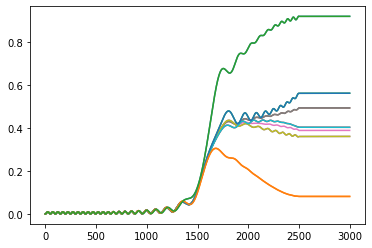

In [20]:
for x in res:
    plt.plot(x)

In [21]:
def heat_detuning(data,start,end):
    time_window = []
    x =[]
    detunings = simul.samples['Global']['ground-rydberg']['det']

    for t,d in enumerate(detunings):
        if start <= d <= end:
            time_window.append(t)
            x.append(d)

    y = np.arange(len(reg.qubits))

    X, Y = np.meshgrid(x, y)
    Z = np.array(data)[:,time_window]

    plt.figure(figsize=(20,3))
    plt.pcolormesh(X,Y,Z, cmap='hot', shading='auto')

    plt.show()

In [ ]:
heat_detuning(res,delta_0,delta_f)

# Rydberg Crystals: Z3 Order

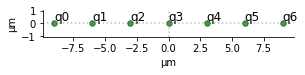

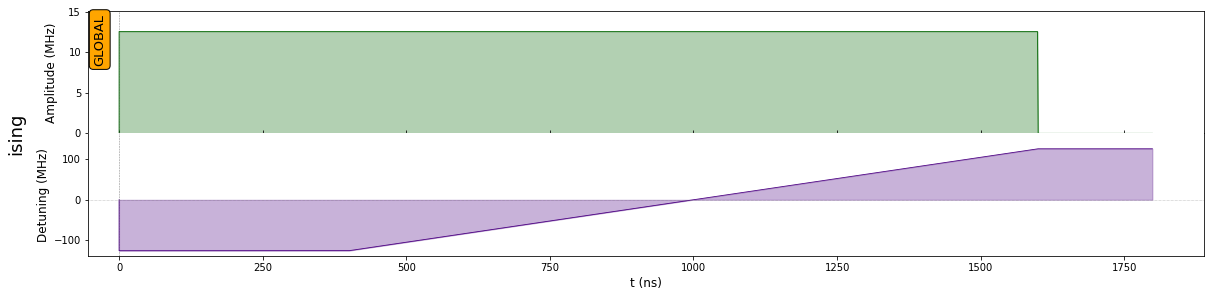

Observables provided. Calculating expectation value...
10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.32s. Est. time left: 00:00:00:01
30.0%. Run time:   0.47s. Est. time left: 00:00:00:01
40.0%. Run time:   0.62s. Est. time left: 00:00:00:00
50.0%. Run time:   0.77s. Est. time left: 00:00:00:00
60.0%. Run time:   0.94s. Est. time left: 00:00:00:00
70.0%. Run time:   1.41s. Est. time left: 00:00:00:00
80.0%. Run time:   1.88s. Est. time left: 00:00:00:00
90.0%. Run time:   2.34s. Est. time left: 00:00:00:00
Total run time:   2.80s


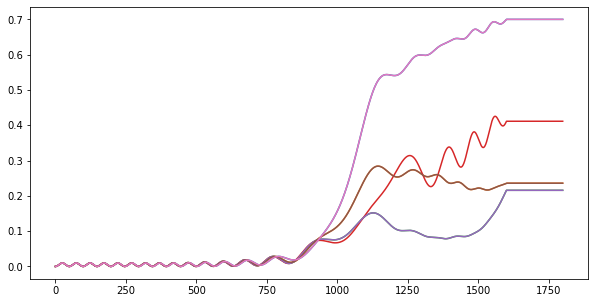

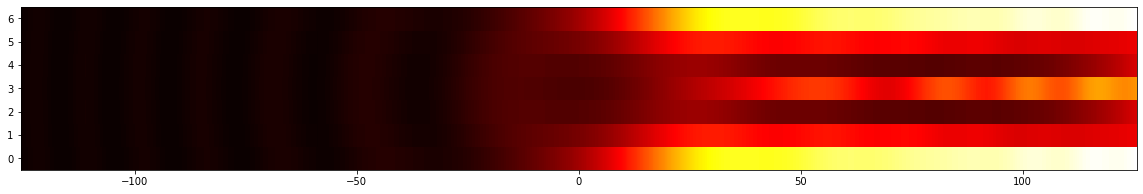

In [27]:
reg = Register.rectangle(1,7, spacing=3., prefix='q')
reg.draw()

delta_0 = -20 * 2*np.pi
delta_f = 20 * 2*np.pi
Omega_max = 2.0 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 400
t_stop = 1600
t_end = 1800

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

#
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

#print(seq)
seq.draw()

simul = Simulation(seq)

#
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

#
simul.run(obs_list=occup_list, progress_bar=True)
res = simul.output.expect

plt.figure(figsize=(10,5))
for expv in simul.output.expect:
    plt.plot(expv)
    
heat_detuning(res,delta_0,delta_f)
    
plt.show()

# Rydberg Crystals: Z4 Order

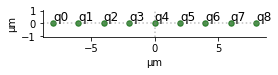

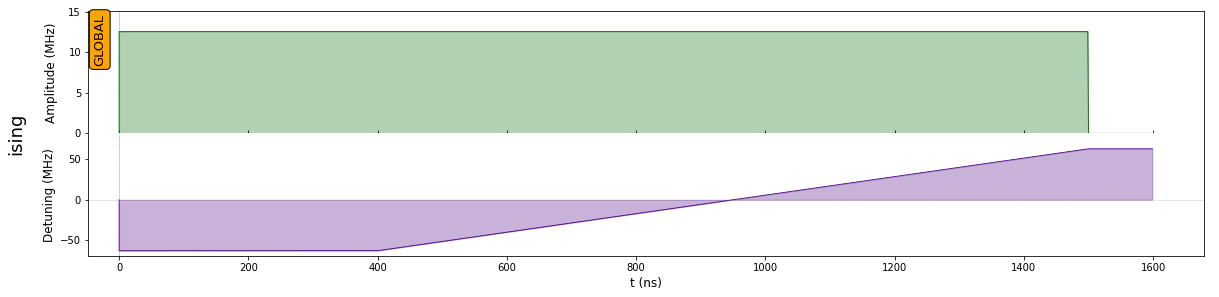

Observables provided. Calculating expectation value...
10.0%. Run time:  10.48s. Est. time left: 00:00:01:34
20.0%. Run time:  27.03s. Est. time left: 00:00:01:48
30.0%. Run time:  44.93s. Est. time left: 00:00:01:44
40.0%. Run time:  61.79s. Est. time left: 00:00:01:32
50.0%. Run time:  79.11s. Est. time left: 00:00:01:19
60.0%. Run time:  97.33s. Est. time left: 00:00:01:04
70.0%. Run time: 114.87s. Est. time left: 00:00:00:49
80.0%. Run time: 131.65s. Est. time left: 00:00:00:32
90.0%. Run time: 148.39s. Est. time left: 00:00:00:16
Total run time: 165.39s


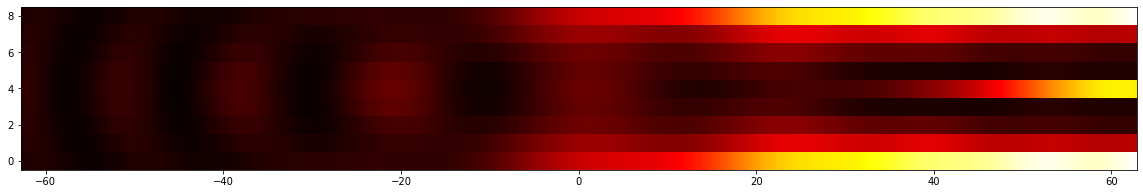

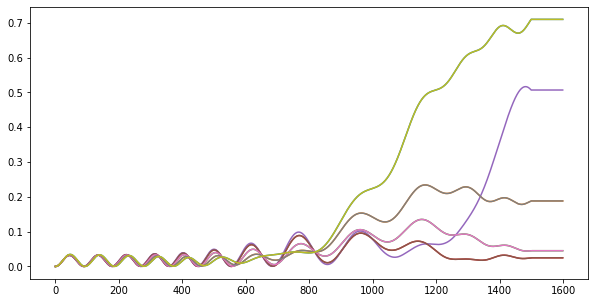

In [25]:
reg = Register.rectangle(1,9, spacing=2., prefix='q')
reg.draw()

# Parameters in MHz and ns
#U = 1 * 2*np.pi  # btw 1-3 Mhz*2pi. Should we include this VdW magnitude in an AFM-type Simulation?

delta_0 = -10 * 2*np.pi
delta_f = 10 * 2*np.pi
Omega_max = 2.0 * 2*np.pi  # btw 1.8-2 Mhz*2pi
t_rise = 400
t_stop = 1500
t_end = 1600

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

#
seq = Sequence(reg, Mock)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

#print(seq)
seq.draw()

simul = Simulation(seq)

#
up = qutip.basis(2,0)
def occupation(j):
    prod = [qutip.qeye(2) for _ in range(simul._size)]
    prod[j] = up*up.dag()
    return qutip.tensor(prod)
    
occup_list = [occupation(j) for j in range(simul._size)]

#
simul.run(obs_list=occup_list, progress_bar=True)
res = simul.output.expect
        
heat_detuning(res,delta_0,delta_f)
    
#
plt.figure(figsize=(10,5))
for expv in simul.output.expect:
    plt.plot(expv)
    
plt.show()